[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mayo-Radiology-Informatics-Lab/MIDeL/blob/main/chapters/9B.ipynb)

*Author: Bardia Khosravi, MD*

# Transfer Learning and Fine-tuning

## 1. Introduction

<img src="https://cv.gluon.ai/_images/imagenet_banner.jpeg">

Transfer learning is a technique in machine learning where a model trained on one task is repurposed to do a related task. It has become a highly popular technique in developing deep learning models, particularly in the field of medical imaging. The idea behind transfer learning is to leverage the knowledge (represented in the weights of the trained model) gained from solving one problem and apply it to a different but related problem. This can save time and computational resources, and can also help overcome the problem of data scarcity.

In transfer learning, the neural network is trained in two stages: pretraining and fine-tuning. In pretraining, the network is generally trained on a large-scale benchmark dataset representing a wide diversity of labels or categories. In fine-tuning, the pretrained network is further trained on the specific target task of interest, which may have fewer labeled examples than the pretraining dataset. The pretraining step helps the network learn general features that can be reused on the target task.

This kind of two-stage paradigm has become extremely popular in many settings, and particularly so in medical imaging. Standard architectures designed for natural image datasets such as ImageNet, together with corresponding pretrained weights, are fine-tuned on medical tasks ranging from interpreting chest x-rays and identifying eye diseases to early detection of Alzheimer’s disease.

Pretraining can be done in a supervised or unsupervised manner.

- Supervised pretraining involves training the model on a labeled dataset, where the model is provided with both the input data and the desired output.
- Self-supervised pretraining, on the other hand, involves training the model on an unlabeled dataset, where the model is only provided with the input data and must learn to identify patterns and relationships in the data on its own.

## 2. Training

In this part, we will start by training a simple classifier using the MedNIST dataset. We will use [MONAI](https://monai.io/) library. MONAI is a PyTorch-based, open-source framework for deep learning in healthcare imaging. It provides domain-optimized foundational capabilities for developing healthcare imaging training workflows in a native PyTorch paradigm.

### 2.1. Imports

We first have to install `monai` and `timm` libraries. Timm, is a pytorch-based package that contains many pre-trained architectures.

In [ ]:
!pip install -q monai timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.7 MB/s eta 0:00:00


Now we can import all the required libraries.

In [ ]:
import os
import random
import copy
import numpy as np
import torch
from tqdm.auto import tqdm
import timm
import monai as mn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

We will use `wget` to download the MedNIST dataset. This copies the images from a Dropbox file to our computer, where we can operate on them. If you are running this in colab, it copies them to the google computer you are using.

In [ ]:
!wget "https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz" -nv
!tar -xf "./MedNIST.tar.gz"
!rm "./MedNIST.tar.gz"

2023-08-11 17:32:58 URL:https://uc9935eaa9782d52b5a1aab3a05b.dl.dropboxusercontent.com/cd/0/inline2/CBl_afXeIB51iag9t8_DkRPeQdJ6S0zTA-3XYzAOABrSIv2OWHqL3YTM0zTKtkwXEEt3Y7zzHG4Xde2cSFUmAsWEmNvERf1Jr7sPHfZ2KoNkVqZgX1HNwCAUfTD9qrU4OZSfyDIAlI0b9QlewYvvukTfyzk9v_R198glejK-Ar7kkdP37fr50XnHZgdps0tgsDYNYp-Vl8-MEAGtt9WQpekjDeUUar3I8LoAn7bGcBiF5KKVFzeCEtdGcv4lipbEhAqo8MrKZZgwF86Ljp4uVzjXiU_LDUsFaBlol0g4kh6PF1iWsq95bx-V4GF0s8xhJBvitmlwuY0MuO2RFvlnusQ-JxQWc2PXhw2FGzb64QWYAQ/file [61834679/61834679] -> "MedNIST.tar.gz" [1]


MedNIST is a dataset of 58,000 images of size 64x64, across 6 classes of medical images: Hand, ChestCT, CXR, AbdomenCT, BreastMRI, and HeadCT. The dataset was created by Dr. Bradley J. Erickson M.D., Ph.D., a professor of radiology at Mayo Clinic, for educational purposes. The dataset is licensed under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License.

### 2.2. Utility Functions (Data)

We will use a seeding function to make our work reproducible!

In [ ]:
def seed_everything(seed: int = 42):
    """sets the seed for all libraries

    Args:
        seed (int, optional): seed value. Defaults to 42.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    mn.utils.misc.set_determinism(seed=seed)

We also need a helper function that creates a list of dictionaries for the images in our dataset. This interface is recommended when working with MONAI.

In [ ]:
def get_data_dict():
    data_dir = "./MedNIST"
    class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
    num_class = len(class_names)

    image_files = [[os.path.join(data_dir, class_name, x) for x in os.listdir(os.path.join(data_dir, class_name))] for class_name in class_names]
    image_files_list = []
    image_class = []
    class_dict = {}
    for i, class_name in enumerate(class_names):
        class_dict[i] = class_name
        image_files_list.extend(image_files[i])
        image_class.extend([i] * len(image_files[i]))

    data_dicts = [{"image": image_name, "label": label} for image_name, label in zip(image_files_list, image_class)]
    return data_dicts, class_dict

### 2.3. Data Handling

First, create a dictionary of image file paths and labels using the `get_data_dict` function. We also check the number of images and the class names.

In [ ]:
data_dict, class_dict = get_data_dict()
print(f"Total Number of Images: {len(data_dict)}")
print("Classes:", ", ".join(class_dict.values()))

Total Number of Images: 58954
Classes: AbdomenCT, BreastMRI, CXR, ChestCT, Hand, HeadCT


We then set the random seed using the `seed_everything` function, shuffle the data, and split it into training, validation, and test sets using the `train_test_split` function from scikit-learn. We then print the number of images in each set.

In [ ]:
seed_everything(2023)
random.shuffle(data_dict)

train_val_files, test_files = train_test_split(data_dict, test_size=0.2)
train_files, val_files = train_test_split(train_val_files, test_size=0.2)

print(f"Number of Training Images: {len(train_files)}")
print(f"Number of Validation Images: {len(val_files)}")
print(f"Number of Test Images: {len(test_files)}")

Number of Training Images: 37730
Number of Validation Images: 9433
Number of Test Images: 11791


Finally, we define data transformations for the training and validation sets using MONAI. The training transformations include loading the images, adding a channel dimension, applying random rotations, flips, and zooms, and converting the data to tensors. The validation transformations include loading the images, adding a channel dimension, and converting the data to tensors.

In [ ]:
train_transform = mn.transforms.Compose([
    mn.transforms.LoadImageD(keys="image", ensure_channel_first=True),
    mn.transforms.RandRotateD(keys="image", range_x=15, prob=0.5),
    mn.transforms.RandFlipD(keys="image", prob=0.5),
    mn.transforms.RandZoomD(keys="image", min_zoom=0.9, max_zoom=1.1, prob=0.5),
    mn.transforms.ToTensorD(keys=["image", "label"]),
])
valid_transform = mn.transforms.Compose([
    mn.transforms.LoadImageD(keys="image", ensure_channel_first=True),
    mn.transforms.ToTensorD(keys=["image", "label"]),
])

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


Here, we can check some of the images in our training set. Feel free to change the `sample_idx` variable to see different images. These are very 'pixelated' because the MedNIST dataset is made of 64x64 images.
Think about why we might do this: what are the advantages and disadvantages?

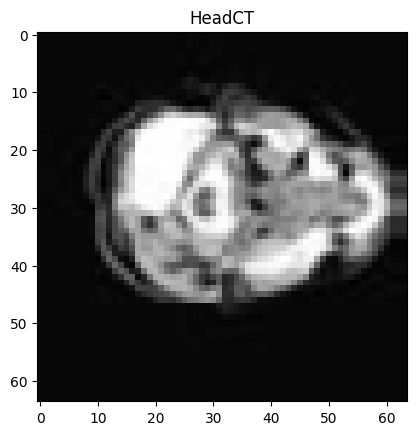

In [ ]:
sample_idx = 178
sample = train_transform(train_files[sample_idx])
plt.imshow(sample["image"][0], cmap="gray");
plt.title(class_dict[sample["label"].item()]);

In the next code block, we create cache directories for the training, validation, and test sets using the `os.makedirs` function. We then create `PersistentDataset` objects for each set using the provided data and transformations. The `PersistentDataset` class from MONAI caches the transformed data to disk to speed up subsequent data loading.

In [ ]:
# Creating cache directories
directories = ["cache/train", "cache/valid", "cache/test"]
for directory in directories:
    os.makedirs(directory, exist_ok=True)

train_ds = mn.data.PersistentDataset(data=train_files, transform=train_transform, cache_dir="cache/train")
val_ds = mn.data.PersistentDataset(data=val_files, transform=valid_transform, cache_dir="cache/valid")
test_ds = mn.data.PersistentDataset(data=test_files, transform=valid_transform, cache_dir="cache/test")

Now, we can have our `DataLoader` object for the three sets.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, num_workers=2, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=128, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=128, num_workers=2)

### 2.4. Utility Functions (Model)

Here, we will define three functions, `one_step`, `train_model` and `test_model`, that are used to train and test a model on a dataset.

The `one_step` function takes a model, a batch of data, a loss function, an optimizer, and a training flag as arguments. It performs a forward pass to compute the model’s predictions and the loss, and if the training flag is set to `True`, it performs a backward pass to update the model’s weights using the optimizer. The function returns the loss value and the predicted probabilities.

In [ ]:
def one_step(model, batch, loss_fn, optimizer, device: str = "cuda:0", training: bool = True):
    """trains the model for one step

    Args:
        model (torch.nn.Module): model
        batch (dict): batch of data
        loss_fn (torch.nn.Module): loss function
        optimizer (torch.optim.Optimizer): optimizer
        training (bool, optional): whether the model is in training mode or not. Defaults to True.

    Returns:
        float: loss value
    """
    x = batch["image"].to(device)
    y = batch["label"].to(device)

    if training:
        model.train()
    else:
        model.eval()

    model = model.to(device)

    with torch.set_grad_enabled(training):
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        if training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    return loss.item(), torch.softmax(y_pred, dim=-1)

The `train_model` function takes a model, train and validation dataloaders, a loss function, and the number of epochs as arguments. It trains the model on the training data for the specified number of epochs using the `one_step` function and evaluates the model on the validation data after each epoch. The best model is saved based on the highest validation AUC.

In [ ]:
def train_model(model, train_dataloader, val_dataloader, loss_fn, weight_filename: str = "best_model", epochs: int = 10, device: str = "cuda:0", param_groups=None):
    """trains the model

    Args:
        model (torch.nn.Module): model architecture
        train_dataloader (torch.utils.data.DataLoader): train dataloader
        val_dataloader (torch.utils.data.DataLoader): validation dataloader
        loss_fn (torch.nn.Module): loss function
        epochs (int, optional): number of epochs. Defaults to 10.
        device (str, optional): device to use. Defaults to "cuda:0".

    Returns:
        torch.nn.Module: best weights of the trained model
    """
    # some hyperparameters that you can use to tune your model
    lr = 1e-4
    weight_decay = 1e-5

    optimizer = torch.optim.AdamW(model.parameters() if param_groups is None else param_groups, lr=lr, weight_decay=weight_decay)

    best_auc = 0.0
    best_model = None

    seed_everything(2023)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        print("-" * 10)

        # Training loop
        train_losses = []
        for i, data in enumerate(tqdm(train_dataloader, desc=f"E {epoch+1}/{epochs} Training")):
            train_loss, _ = one_step(model, data, loss_fn, optimizer, device=device, training=True)
            train_losses.append(train_loss)

        # Validation loop
        val_losses = []
        y_true = []
        y_score = []
        for data in tqdm(val_dataloader, desc=f"E {epoch+1}/{epochs} Validation"):
            val_loss, y_pred = one_step(model, data, loss_fn, optimizer, device=device, training=False)
            val_losses.append(val_loss)
            y_true.extend(data["label"].tolist())
            y_score.extend(y_pred.tolist())

        # Compute AUC on validation set
        auc_total = roc_auc_score(y_true, y_score, multi_class="ovr", average="macro")

        # Print statistics
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        print(f"train loss: {train_loss:.4f}")
        print(f"val loss: {val_loss:.4f}")
        print(f"val total auc: {auc_total:.4f}")

        # Save best model based on validation AUC
        if auc_total > best_auc:
            best_auc = auc_total
            best_model = copy.deepcopy(model.state_dict())
            print("saving best model")
            torch.save(best_model, f"{weight_filename}.pth")

        print("\n")

    return best_model

The `test_model` function takes a model and test dataloader as arguments. It evaluates the model on the test data and computes the AUC. The function returns the total AUC on the test set.

In [ ]:
def test_model(model, test_loader, device: str = "cuda:0"):
    """Tests the model on the test set and returns the AUC

    Args:
        model (torch.nn.Module): model
        test_loader (torch.utils.data.DataLoader): test dataloader
        device (str, optional): device to use. Defaults to "cuda:0".

    Returns:
        tuple: AUC per class and total AUC
    """
    # Test on the test set
    model.eval()
    y_true = []
    y_score = []
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Testing"):
            inputs, labels = data["image"].to(device), data["label"].to(device)
            outputs = model(inputs)
            y_true.extend(labels.tolist())
            y_score.extend(outputs.softmax(dim=1).tolist())

    # Compute AUC on test set
    auc_total = roc_auc_score(y_true, y_score, multi_class="ovr", average="macro")

    return auc_total

### 2.5. Training

In this code block, we train a `convnext-femto` model from scratch on the MedNIST dataset. First, we set the device to GPU if it is available, otherwise we use the CPU. Then, we import a `convnext-femto` model from the `timm` library and set the number of output classes to match the number of classes in our dataset. We also set the number of input channels to 1 since our images are grayscale. Next, we define our loss function as the cross-entropy loss, which is commonly used for multi-class classification problems. Finally, we use the `train_model` function to train our model on the training data and evaluate it on the validation data. The best model weights are saved based on the highest validation AUC.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model("convnext_femto", num_classes=len(class_dict), in_chans=1)
loss_fn = torch.nn.CrossEntropyLoss()

sc_best_model_weights = train_model(model, train_loader, val_loader, loss_fn, weight_filename="best_model", epochs=1, device=device)

Epoch 1/1
----------


E 1/1 Training:   0%|          | 0/295 [00:00<?, ?it/s]

E 1/1 Validation:   0%|          | 0/74 [00:00<?, ?it/s]

train loss: 0.6364
val loss: 0.2487
val total auc: 0.9915
saving best model




Now, we test our model on the test set.

In [ ]:
model.load_state_dict(sc_best_model_weights)
test_auc = test_model(model, test_loader, device=device)

print(f"Random Initialization AUC on Test set: {test_auc:0.5f}")

Testing:   0%|          | 0/93 [00:00<?, ?it/s]

Random Initialization AUC on Test set: 0.99194


Although the task is very easy, it has a very good performance in only one epoch!

Let's see if we can improve our results with transfer learning. For this, we use the `pretrained` flag from the `timm` library. When set to `True` the model's weight are set to the ones pretrained on the large ImageNet dataset.

In [ ]:
model = timm.create_model("convnext_femto", num_classes=len(class_dict), in_chans=1, pretrained=True)

tl_best_model_weights = train_model(model, train_loader, val_loader, loss_fn, weight_filename="best_model", epochs=1, device=device)

Epoch 1/1
----------


E 1/1 Training:   0%|          | 0/295 [00:00<?, ?it/s]

E 1/1 Validation:   0%|          | 0/74 [00:00<?, ?it/s]

train loss: 0.0521
val loss: 0.0013
val total auc: 1.0000
saving best model




Let's see how good our model is on the test set.

In [ ]:
model.load_state_dict(tl_best_model_weights)
test_auc = test_model(model, test_loader, device=device)

print(f"Transfer Learning AUC on Test set: {test_auc:0.5f}")

Testing:   0%|          | 0/93 [00:00<?, ?it/s]

Transfer Learning AUC on Test set: 1.00000


Well we can see the improvement! At least we can say that the model learns faster! Now let's see if we can get good results with smaller training sets.

For this, we will select 10% of our data and train the model on that.

In [ ]:
train_ds_small = mn.data.PersistentDataset(data=train_files[:len(train_files)//10], transform=train_transform, cache_dir="cache/train")
train_loader_small = torch.utils.data.DataLoader(train_ds_small, batch_size=128, num_workers=2, shuffle=True)

First, let's try a a model with random weight initialization.

In [ ]:
model = timm.create_model("convnext_femto", num_classes=len(class_dict), in_chans=1, pretrained=False)

sc_10p_best_model_weights = train_model(model, train_loader_small, val_loader, loss_fn, weight_filename="best_model", epochs=1, device=device)

model.load_state_dict(sc_10p_best_model_weights)
test_auc = test_model(model, test_loader, device=device)

print(f"Random Initialization AUC on Test set (10%): {test_auc:0.5f}")

Epoch 1/1
----------


E 1/1 Training:   0%|          | 0/30 [00:00<?, ?it/s]

E 1/1 Validation:   0%|          | 0/74 [00:00<?, ?it/s]

train loss: 1.4252
val loss: 1.2267
val total auc: 0.8694
saving best model




Testing:   0%|          | 0/93 [00:00<?, ?it/s]

Random Initialization AUC on Test set (10%): 0.87028


This makes sense. The more diverse data we have, the better our model will learn!

Now, let's see the effect of transfer learning.

In [ ]:
model = timm.create_model("convnext_femto", num_classes=len(class_dict), in_chans=1, pretrained=True)

tl_10p_best_model_weights = train_model(model, train_loader_small, val_loader, loss_fn, weight_filename="best_model", epochs=1, device=device)

model.load_state_dict(tl_10p_best_model_weights)
test_auc = test_model(model, test_loader, device=device)

print(f"Transfer Learning AUC on Test set (10%): {test_auc:0.5f}")

Epoch 1/1
----------


E 1/1 Training:   0%|          | 0/30 [00:00<?, ?it/s]

E 1/1 Validation:   0%|          | 0/74 [00:00<?, ?it/s]

train loss: 0.3933
val loss: 0.0295
val total auc: 1.0000
saving best model




Testing:   0%|          | 0/93 [00:00<?, ?it/s]

Transfer Learning AUC on Test set (10%): 0.99998


You see now the difference is much more pronounced!

Transfer learning is a powerful technique that allows us to leverage pre-existing knowledge from related tasks to improve the performance of our models. By initializing our model with weights from a pre-trained model, we can significantly reduce the amount of training data and time required to achieve good performance. This is especially useful when working with small datasets or complex models that would otherwise be difficult to train from scratch. To make the most of transfer learning, it is important to choose a pre-trained model that is related to our task and has been trained on a large and diverse dataset. It is also important to fine-tune the pre-trained weights on our specific task to adapt them to our data.

The last technique is using differential learning rates for different layers of a model can be a useful technique when fine-tuning a pre-trained model or when training a model with a complex architecture. The idea is to assign higher learning rates to the later layers of the model, which are more task-specific, and lower learning rates to the earlier layers, which capture more general features. This allows the later layers to adapt more quickly to the new task while preserving the pre-trained knowledge in the earlier layers. By carefully tuning the learning rates for each layer, we can achieve better performance and faster convergence when fine-tuning or training our model.

In [ ]:
model = timm.create_model("convnext_femto", num_classes=len(class_dict), in_chans=1, pretrained=True)

param_groups = [
    {"params": [p for n, p in model.named_parameters() if "head" in n], "lr": 1e-4},
    {"params": [p for n, p in model.named_parameters() if "stages.3" in n], "lr": 1e-5},
    {"params": [p for n, p in model.named_parameters() if "stages.2" in n], "lr": 1e-6},
    {"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in ["head", "stages.3", "stages.2"])], "lr": 1e-7},
]

tl_clr_10p_best_model_weights = train_model(model, train_loader_small, val_loader, loss_fn, weight_filename="best_model", epochs=1, device=device, param_groups=param_groups)

model.load_state_dict(tl_clr_10p_best_model_weights)
test_auc = test_model(model, test_loader, device=device)

print(f"Transfer Learning (Custom LR) AUC on Test set (10%): {test_auc:0.5f}")

Epoch 1/1
----------


E 1/1 Training:   0%|          | 0/30 [00:00<?, ?it/s]

E 1/1 Validation:   0%|          | 0/74 [00:00<?, ?it/s]

train loss: 1.4358
val loss: 0.9952
val total auc: 0.9641
saving best model




Testing:   0%|          | 0/93 [00:00<?, ?it/s]

Transfer Learning (Custom LR) AUC on Test set (10%): 0.96564


## 3. Further Reading
1. [OpenAI Microscope](https://microscope.openai.com/models): This is a fun tool for visualizing network features!
2. [SSL in Medicine](https://peerj.com/articles/cs-1045/): This paper provides a great overview on self-supervised techniques that can be used in medicine.
3. [RadImageNet](https://github.com/BMEII-AI/RadImageNet): This is an open-source medical dataset that can be used for model pre-training. They also have some limited pretrained models.